# Julia(Chars74K)字母圖像辨識

Kaggle的[First Steps With Julia](https://www.kaggle.com/c/street-view-getting-started-with-julia)比賽是一個圖像的分類問題。這些字符圖像來自Chars74k數據集的一個子集。這個比賽通常作為如何使用Julia語言的教程，但這我們將透過Keras來建構一個卷積神經網絡(CNN)並使用圖像增強的手法來強化模型的辨識能力。

![Chars74K](http://ankivil.com/wp-content/uploads/2016/09/Kaggle_FirstStepsJulia_Cover-816x459.png)

## 資料預處理 (Data Preprocessing)
首先，你必須先從Kaggle下載[Julia(Chars74K)](https://www.kaggle.com/c/street-view-getting-started-with-julia/data/)相關數據並在解壓縮到本機的特定檔案目錄。

In [1]:
# 資料預處理 (Data Preprocessing)
import os
import glob
import pandas as pd
import math
import numpy as np
from scipy.misc import imread, imsave, imresize
from natsort import natsorted

### 圖像的色彩 (Image Color)

訓練和測試資料集中幾乎所有圖像都是彩色圖像。預處理的第一步是將所有圖像轉換為灰階。它簡化了輸入到網絡的數據，也讓模型更能夠一般化(generalize)，因為一個藍色的字母與一個紅色字母在這個圖像的分類問題上都是相同的。因此把圖像顏色的通道(channel)進行縮減的這個預處理應該對最終的準確性沒有負面影響，因為大多數文本與背景具有高度對比。

### 圖像大小的修改 (Image Resizing)

由於圖像具有不同的形狀和大小，因此我們必須對圖像進行歸一化(normalize)處理以便可以決定模型的輸入。這個處理會有兩個主要的問題需要解決：我們選擇哪種圖像大小(size)？我們是否該保持圖像寬高比(aspect ratio)?

起初，我也認為保持圖像的高寬比會更好，因為它不會任意扭曲圖像。這也可能導致O和O（大寫o和零）之間的混淆。不過，經過一番測試，似乎沒有保持寬高比的模型效果更好。

關於圖像尺寸，16×16的圖像允許非常快速的訓練，但不能給出最好的結果。這些小圖像是快速測試想法的完美選擇。使用32×32的圖像使訓練相當快，並提供良好的準確性。最後，與32×32圖像相比，使用64×64圖像使得訓練相當緩慢並略微提高了結果。我選擇使用32×32的圖像，因為它是速度和準確性之間的最佳折衷。

In [ ]:
# 圖像資料的檔案路徑
path = "data"

# 圖像轉換後的目標大小 (32像素 x 32像素)
img_height, img_width = 32, 32

# 轉換圖像後的儲存目錄
suffix = "Preproc"
trainDataPath = path + "/train" + suffix
testDataPath = path + "/test" + suffix

# 產生目錄
if not os.path.exists(trainDataPath):
    os.makedirs(trainDataPath)

if not os.path.exists(testDataPath):
    os.makedirs(testDataPath)
    
### 圖像大小與圖像的色彩的預處理 ###

for datasetType in ["train","test"]:
    # 透過natsorted可以讓回傳的檔案名稱的排序
    imgFiles = natsorted(glob.glob(path + "/" + datasetType + "/*"))
    
    # 初始一個ndarray物件來暫存讀進來的圖像資料
    imgData = np.zeros((len(imgFiles), img_height, img_width))
    
    # 使用迴圈來處理每一筆圖像檔
    for i, imgFilePath in enumerate(imgFiles):
        # 圖像的色彩 (Image Color)處理
        img = imread(imgFilePath, True) # True: 代表讀取圖像時順便將多階圖像, 打平成灰階(單一通道:one channel)
        
        # 圖像大小的修改 (Image Resizing)
        imgResized = imresize(img, (img_height, img_width))
        
        # 把圖像資料儲放在暫存記憶體中
        imgData[i] = imgResized
        
        # 將修改的圖像儲存到檔案系統 (方便視覺化了解)
        filename = os.path.basename(imgFilePath)
        filenameDotSplit = filename.split(".")
        newFilename = str(int(filenameDotSplit[0])).zfill(5) + "." + filenameDotSplit[-1].lower()
        newFilepath = path + "/" + datasetType + suffix + "/" + newFilename
        imsave(newFilepath, imgResized)
    
    # 新增加"Channel"的維度
    print("Before: ", imgData.shape)
    imgData = imgData[:,:,:,np.newaxis] # 改變前: []
    print("After: ", imgData.shape)
    
    # 進行資料(pixel值)標準化
    imgData = imgData.astype('float32')/255
    
    # 以numpy物件將圖像轉換後的ndarray物件保存在檔案系統中
    np.save(path + "/" + datasetType + suffix + ".npy", imgData)

### 標籤轉換 (Label Conversion)

我們也必須將字符的標籤進行one-hot編碼的轉換。將標籤信息提供給CNN神經網絡是必要的。這個過程包括了兩個步驟。
首先，我們將字符轉換為連續整數。由於要預測的字符是[0~9],[a~z]及[A~Z]共有62個字符, 所以我們將把每個字符
對應到[0~61]的整數。 

再來，我們將每個對應到某個字符的整數值去進行one-hot的編碼轉換成為一個向量。

In [2]:
# 標籤轉換 (Label Conversion)
import keras

def label2int(ch):
    asciiVal = ord(ch)
    if(asciiVal<=57): #0-9
        asciiVal-=48
    elif(asciiVal<=90): #A-Z
        asciiVal-=55
    else: #a-z
        asciiVal-=61
    return asciiVal
    
def int2label(i):
    if(i<=9): #0-9
        i+=48
    elif(i<=35): #A-Z
        i+=55
    else: #a-z
        i+=61
    return chr(i)

# 圖像資料的檔案路徑
path = "data"

# 載入標籤資料
y_train = pd.read_csv(path + "/trainLabels.csv").values[:,1] #只保留"標籤資料"欄

# 對標籤(Label)進行one-hot編碼
Y_train = np.zeros((y_train.shape[0], 62)) # A-Z, a-z, 0-9共有62個類別

for i in range(y_train.shape[0]):
    Y_train[i][label2int(y_train[i])] = 1 # One-hot

# 把轉換過的標籤(Label)資料保存在檔案系統便於後續的快速載入與處理
np.save(path + "/" + "labelsPreproc.npy", Y_train)


Using TensorFlow backend.


## 圖像增強 (Data Augmentation)

這次我們要對於訓練數據的使用手法上有一些不同，主要的是想要應用一些圖像增強的技術來人為地增加“新”圖像到訓練資料集中。增量是對於原始的圖像進行一些隨機變換以產生新的圖像。這些轉換可以是縮放，旋轉，位移..等或所有這些的組合。

方便的是，Keras中有一個圖像增強類別：ImageDataGenerator 可以讓我們很輕鬆地就達成任務

### 使用 ImageDataGenerator

ImageDataGenerator構建函數需要幾個參數來定義我們想要使用的增強效果。我只會通過對我們的案例有用的參數進行設定，如果您需要對您的圖像進行其他修改，請參閱[Keras文檔](https://keras.io/preprocessing/image/)。

* `featurewise_center`，`featurewise_std_normalization`和`zca_whitening`不使用，因為在本案例裡它們不會增加網絡的性能。如果你想測試這些選項，一定要合適地計算相關的數量，並將這些修改應用到你的測試集中進行標準化。
* `rotation_range` 20左右的值效果最好。
* `width_shift_range` 0.15左右的值效果最好。
* `height_shift_range` 0.15左右的值效果最好。
* `shear_range 0.4` 左右的值效果最好。
* `zoom_range 0.3` 左右的值效果最好。
* `channel_shift_range` 0.1左右的值效果最好。

當然，我沒有測試所有的組合，所以可能還有其他值的組合可以用來提高最終的準確度。但要小心，太多的增量（高參數值）會使學習變得緩慢甚至跑不出來。



## 網絡模型 (Model)

我嘗試了兩種不同的網絡模型結構：
* Vikesh的CNN-2你可以在他的[文章](http://cs231n.stanford.edu/reports/vikesh_final.pdf)中找到細節。整個Chars74k數據集的準確率為86.52%。然而，在這個Kaggle比賽裡，我們只使用Chars74k的一個子集，這個模型我只能設法獲得大約80%的驗證準確度。
* Florian Muellerklein的類VGG網絡模型結構，你可以在[這裡](http://florianmuellerklein.github.io/cnn_streetview/)找到細節。這個是我跑出來最好分數的模型，超過85%的驗證準確性，所以我會詳細描述它。

一圖勝千言，下面是模型的結構圖：
![VGG-like](http://ankivil.com/wp-content/uploads/2016/09/CNN_final_model.png)

這個模型與Florian Muellerklein非常相似。我在卷積層設定了zero-padding，並增加了密集層的大小。Dropout設定為0.5。

這個模型給出了最好的結果，但是學習起來很慢很花時間。通過將所有濾波器數量和密集的圖層大小除以2或4，您也可以得到很好的結果。
較小的網絡對於測試不同的超參數非常有用。值得注意的是，增加網絡的規模確實提高了驗證的準確性，但也成倍地增加了模型學習的時間。

我也嘗試添加一些圖層，但產生的網絡難以收斂，並沒有給出好的結果。

## 模型學習 (Learning)

對於模型的訓練，我使用了分類交叉熵(cross-entropy)作為損失函數(loss function)，最後一層使用softmax的激勵函數。

### 演算法 (Algorithm)

在這個模型裡我選擇使用`AdaMax`和`AdaDelta`來作為優化器(optimizer)，而不是使用經典的隨機梯度下降（SGD）算法。
同時我發現`AdaMax`比`AdaDelta`在這個問題上會給出更好的結果。

但是，對於具有眾多濾波器和大型完全連接層的複雜網絡，AdaMax在訓練循環不太收斂，甚至無法完全收斂。因此在這次的網絡訓練過程我拆成二個階段。
第一個階段，我先使用`AdaDelta`進行了20個循環的前期訓練為的是要比較快速的幫忙卷積網絡的模型收斂。第二個階段，則利用`AdaMax`來進行更多訓練循環與更細微的修正來得到更好的模型。

如果將網絡的大小除以2，則不需要使用該策略。

### 訓練批次量 (Batch Size)

在保持訓練循環次數不變的同時，我試圖改變每次訓練循環的批量大小(batch size)。大的批量(batch)會使算法運行速度更快，但結果效能不佳。
這可能是因為在相同數量的數據量下，更大的批量意味著更少的模型權重的更新。無論如何，在這個範例中最好的結果是在批量(batch size) 設成
128的情況下達到的。

### 網絡層的權重初始 (Layer Initialization)

如果網絡未正確初始化，則優化算法可能無法找到最佳值。我發現使用`he_normal`來進行初始化會使模型的學習變得更容易。在Keras中，你只需要為每一層使用`kernel_initializer='he_normal'`參數。


### 學習率衰減 (Learning Rate Decay)

在訓練期間逐漸降低學習率(learning rate)通常是一個好主意。它允許算法微調參數，並接近局部最小值。
但是，我發現使用`AdaMax`的optimizer，在沒有設定學習速率衰減的情況下結果更好，所以我們現在不必擔心。

### 訓練循環 (Number of Epochs)

使用128的批量大小，沒有學習速度衰減，我測試了200到500個訓練循環。即使運行到第500個訓練循環，整個網絡模型似乎也沒出現過擬合(overfitting)的情形。
我想這肯定要歸功於Dropout的設定發揮了功效。我發現500個訓練循環的結果比300個訓練循環略好。最後的模型我用了500個訓練循環，但是如果你在CPU上運行，300個訓練循環應該就足夠了。

### 交叉驗證 (Cross-Validation)

為了評估不同模型的質量和超參數的影響，我使用了蒙特卡洛交叉驗證：我隨機分配了初始數據1/4進行驗證，並將3/4進行學習。
我還使用分裂技術，確保在我們的例子中，每個類別約有1/4圖像出現在測試集中。這導致更穩定的驗證分數。


In [3]:
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

batch_size = 128 # 訓練批次量 (Batch Size)
nb_classes = 62  # A-Z, a-z, 0-9共有62個類別
nb_epoch = 500   # 進行500個訓練循環

# Input image dimensions
# 要輸入到第一層網絡的圖像大小 (32像素 x 32像素)
img_height, img_width = 32, 32

# 相關資料的路徑
path = "data/"

# 載入預處理好的訓練資料與標籤
X_train_all = np.load(path+"/trainPreproc.npy")
Y_train_all = np.load(path+"/labelsPreproc.npy")

# 將資料區分為訓練資料集與驗證資料集
X_train, X_val, Y_train, Y_val = train_test_split(X_train_all, Y_train_all, test_size=0.25, stratify=np.argmax(Y_train_all, axis=1))

# 設定圖像增強(data augmentation)的設定
datagen = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range = 0.4,
    zoom_range = 0.3,                    
    channel_shift_range = 0.1)

### 卷積網絡模型架構 ###
model = Sequential()

model.add(Convolution2D(128,(3, 3), padding='same', kernel_initializer='he_normal', activation='relu', 
                        input_shape=(img_height, img_width, 1)))

model.add(Convolution2D(128,(3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(256,(3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(Convolution2D(256,(3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Convolution2D(512,(3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(Convolution2D(512,(3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))
model.add(Convolution2D(512,(3, 3), padding='same', kernel_initializer='he_normal', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(4096, kernel_initializer='he_normal', activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4096, kernel_initializer='he_normal', activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_classes, kernel_initializer='he_normal', activation='softmax'))

# 展現整個模型架構
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 128)       1280      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 512)         1180160   
__________

In [4]:
### 模型訓練學習 ###

# 首先使用AdaDelta來做第一階段的訓練, 因為AdaMax會無卡住
model.compile(loss='categorical_crossentropy', 
              optimizer='adadelta',  
              metrics=["accuracy"])

# 進行20循環就足夠了
model.fit(X_train, Y_train, batch_size=batch_size,
                    epochs=20, 
                    validation_data=(X_val, Y_val),
                    verbose=1)

# 接著改用AdaMax
model.compile(loss='categorical_crossentropy', 
              optimizer='adamax',  
              metrics=["accuracy"])


# 我們想要保存在訓練過程中驗證結果比較好的模型
saveBestModel = ModelCheckpoint("best.kerasModelWeights", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True)

# 在訓練的過程透過ImageDataGenerator來持續產生圖像資料
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train)/batch_size,
                    epochs=nb_epoch, 
                    validation_data=(X_val, Y_val),
                    callbacks=[saveBestModel],
                    verbose=1)

### 進行預測 ###

# 載入訓練過程中驗證結果最好的模型
model.load_weights("best.kerasModelWeights")

# 載入Kaggle測試資料集
X_test = np.load(path+"/testPreproc.npy")

# 預測字符的類別
Y_test_pred = model.predict_classes(X_test)

# 從類別的數字轉換為字符
vInt2label = np.vectorize(int2label)
Y_test_pred = vInt2label(Y_test_pred) 

# 保存預測結果到檔案系統
np.savetxt(path+"/jular_pred" + ".csv", np.c_[range(6284,len(Y_test_pred)+6284),Y_test_pred], delimiter=',', header = 'ID,Class', comments = '', fmt='%s')


Train on 4712 samples, validate on 1571 samples
Epoch 1/20
4712/4712 [==============================] - 7s 2ms/step - loss: 3.9692 - acc: 0.0548 - val_loss: 3.8141 - val_acc: 0.0535
Epoch 2/20
4712/4712 [==============================] - 4s 919us/step - loss: 3.8019 - acc: 0.0745 - val_loss: 3.6092 - val_acc: 0.1031
Epoch 3/20
4712/4712 [==============================] - 4s 925us/step - loss: 3.7895 - acc: 0.1089 - val_loss: 3.6961 - val_acc: 0.1254
Epoch 4/20
4712/4712 [==============================] - 4s 922us/step - loss: 3.0957 - acc: 0.2674 - val_loss: 2.3153 - val_acc: 0.3730
Epoch 5/20
4712/4712 [==============================] - 4s 926us/step - loss: 2.2733 - acc: 0.4185 - val_loss: 1.5714 - val_acc: 0.5659
Epoch 6/20
4712/4712 [==============================] - 4s 927us/step - loss: 1.6286 - acc: 0.5575 - val_loss: 1.7043 - val_acc: 0.5341
Epoch 7/20
4712/4712 [==============================] - 4s 925us/step - loss: 1.3224 - acc: 0.6382 - val_loss: 1.1770 - val_acc: 0.6677
Ep

Epoch 21/500
37/36 [==============================] - 4s 104ms/step - loss: 0.7385 - acc: 0.7658 - val_loss: 0.6170 - val_acc: 0.8180
Epoch 22/500
37/36 [==============================] - 4s 103ms/step - loss: 0.6998 - acc: 0.7791 - val_loss: 0.6357 - val_acc: 0.8129
Epoch 23/500
37/36 [==============================] - 4s 104ms/step - loss: 0.7375 - acc: 0.7655 - val_loss: 0.6160 - val_acc: 0.8205
Epoch 24/500
37/36 [==============================] - 4s 104ms/step - loss: 0.6805 - acc: 0.7856 - val_loss: 0.5630 - val_acc: 0.8230
Epoch 25/500
37/36 [==============================] - 4s 103ms/step - loss: 0.6637 - acc: 0.7909 - val_loss: 0.6000 - val_acc: 0.8281
Epoch 26/500
37/36 [==============================] - 5s 131ms/step - loss: 0.6618 - acc: 0.7863 - val_loss: 0.6078 - val_acc: 0.8294
Epoch 27/500
37/36 [==============================] - 4s 104ms/step - loss: 0.6197 - acc: 0.7999 - val_loss: 0.6164 - val_acc: 0.8256
Epoch 28/500
37/36 [==============================] - 4s 104ms

Epoch 53/500
37/36 [==============================] - 4s 104ms/step - loss: 0.4040 - acc: 0.8600 - val_loss: 0.6517 - val_acc: 0.8300
Epoch 54/500
37/36 [==============================] - 4s 104ms/step - loss: 0.4152 - acc: 0.8644 - val_loss: 0.5769 - val_acc: 0.8345
Epoch 55/500
37/36 [==============================] - 4s 104ms/step - loss: 0.4047 - acc: 0.8637 - val_loss: 0.5980 - val_acc: 0.8364
Epoch 56/500
37/36 [==============================] - 4s 104ms/step - loss: 0.4205 - acc: 0.8598 - val_loss: 0.6209 - val_acc: 0.8358
Epoch 57/500
37/36 [==============================] - 4s 104ms/step - loss: 0.4039 - acc: 0.8661 - val_loss: 0.6333 - val_acc: 0.8364
Epoch 58/500
37/36 [==============================] - 4s 104ms/step - loss: 0.3916 - acc: 0.8615 - val_loss: 0.5998 - val_acc: 0.8332
Epoch 59/500
37/36 [==============================] - 4s 104ms/step - loss: 0.3578 - acc: 0.8757 - val_loss: 0.5975 - val_acc: 0.8364
Epoch 60/500
37/36 [==============================] - 4s 104ms

37/36 [==============================] - 4s 104ms/step - loss: 0.2827 - acc: 0.8946 - val_loss: 0.6542 - val_acc: 0.8313
Epoch 87/500
37/36 [==============================] - 4s 104ms/step - loss: 0.2603 - acc: 0.9099 - val_loss: 0.7248 - val_acc: 0.8339
Epoch 88/500
37/36 [==============================] - 4s 104ms/step - loss: 0.2527 - acc: 0.9126 - val_loss: 0.6729 - val_acc: 0.8281
Epoch 89/500
37/36 [==============================] - 4s 104ms/step - loss: 0.2762 - acc: 0.9071 - val_loss: 0.6409 - val_acc: 0.8434
Epoch 90/500
37/36 [==============================] - 4s 103ms/step - loss: 0.2826 - acc: 0.9057 - val_loss: 0.6965 - val_acc: 0.8326
Epoch 91/500
37/36 [==============================] - 4s 104ms/step - loss: 0.2760 - acc: 0.9047 - val_loss: 0.6528 - val_acc: 0.8409
Epoch 92/500
37/36 [==============================] - 4s 104ms/step - loss: 0.2490 - acc: 0.9172 - val_loss: 0.7456 - val_acc: 0.8364
Epoch 93/500
37/36 [==============================] - 4s 103ms/step - loss:

37/36 [==============================] - 4s 103ms/step - loss: 0.2335 - acc: 0.9223 - val_loss: 0.6419 - val_acc: 0.8383
Epoch 120/500
37/36 [==============================] - 4s 104ms/step - loss: 0.2187 - acc: 0.9197 - val_loss: 0.6482 - val_acc: 0.8511
Epoch 121/500
37/36 [==============================] - 4s 105ms/step - loss: 0.2180 - acc: 0.9250 - val_loss: 0.7027 - val_acc: 0.8402
Epoch 122/500
37/36 [==============================] - 4s 104ms/step - loss: 0.2254 - acc: 0.9182 - val_loss: 0.7382 - val_acc: 0.8345
Epoch 123/500
37/36 [==============================] - 4s 104ms/step - loss: 0.2168 - acc: 0.9272 - val_loss: 0.7344 - val_acc: 0.8313
Epoch 124/500
37/36 [==============================] - 4s 104ms/step - loss: 0.2173 - acc: 0.9287 - val_loss: 0.6971 - val_acc: 0.8307
Epoch 125/500
37/36 [==============================] - 4s 104ms/step - loss: 0.1976 - acc: 0.9335 - val_loss: 0.7635 - val_acc: 0.8313
Epoch 126/500
37/36 [==============================] - 4s 104ms/step 

Epoch 152/500
37/36 [==============================] - 4s 105ms/step - loss: 0.1966 - acc: 0.9367 - val_loss: 0.6949 - val_acc: 0.8523
Epoch 153/500
37/36 [==============================] - 4s 104ms/step - loss: 0.1838 - acc: 0.9350 - val_loss: 0.7462 - val_acc: 0.8447
Epoch 154/500
37/36 [==============================] - 4s 104ms/step - loss: 0.1779 - acc: 0.9378 - val_loss: 0.7737 - val_acc: 0.8447
Epoch 155/500
37/36 [==============================] - 4s 104ms/step - loss: 0.1656 - acc: 0.9421 - val_loss: 0.8352 - val_acc: 0.8351
Epoch 156/500
37/36 [==============================] - 4s 104ms/step - loss: 0.1688 - acc: 0.9371 - val_loss: 0.7778 - val_acc: 0.8320
Epoch 157/500
37/36 [==============================] - 4s 104ms/step - loss: 0.1662 - acc: 0.9421 - val_loss: 0.7956 - val_acc: 0.8364
Epoch 158/500
37/36 [==============================] - 4s 104ms/step - loss: 0.1835 - acc: 0.9387 - val_loss: 0.7609 - val_acc: 0.8281
Epoch 159/500
37/36 [==============================] - 

Epoch 185/500
37/36 [==============================] - 4s 104ms/step - loss: 0.1388 - acc: 0.9517 - val_loss: 0.8131 - val_acc: 0.8339
Epoch 186/500
37/36 [==============================] - 4s 103ms/step - loss: 0.1549 - acc: 0.9464 - val_loss: 0.7539 - val_acc: 0.8498
Epoch 187/500
37/36 [==============================] - 4s 104ms/step - loss: 0.1507 - acc: 0.9505 - val_loss: 0.8096 - val_acc: 0.8396
Epoch 188/500
37/36 [==============================] - 4s 104ms/step - loss: 0.1544 - acc: 0.9471 - val_loss: 0.8447 - val_acc: 0.8402
Epoch 189/500
37/36 [==============================] - 4s 104ms/step - loss: 0.1328 - acc: 0.9545 - val_loss: 0.8441 - val_acc: 0.8390
Epoch 190/500
37/36 [==============================] - 4s 104ms/step - loss: 0.1484 - acc: 0.9533 - val_loss: 0.7995 - val_acc: 0.8440
Epoch 191/500
37/36 [==============================] - 4s 104ms/step - loss: 0.1491 - acc: 0.9526 - val_loss: 0.7635 - val_acc: 0.8409
Epoch 192/500
37/36 [==============================] - 

Epoch 218/500
37/36 [==============================] - 4s 103ms/step - loss: 0.1240 - acc: 0.9595 - val_loss: 0.8464 - val_acc: 0.8440
Epoch 219/500
37/36 [==============================] - 4s 104ms/step - loss: 0.1192 - acc: 0.9603 - val_loss: 0.8091 - val_acc: 0.8453
Epoch 220/500
37/36 [==============================] - 4s 104ms/step - loss: 0.1289 - acc: 0.9557 - val_loss: 0.8498 - val_acc: 0.8409
Epoch 221/500
37/36 [==============================] - 4s 104ms/step - loss: 0.1224 - acc: 0.9578 - val_loss: 0.8433 - val_acc: 0.8485
Epoch 222/500
37/36 [==============================] - 4s 104ms/step - loss: 0.1356 - acc: 0.9597 - val_loss: 0.7811 - val_acc: 0.8377
Epoch 223/500
37/36 [==============================] - 4s 104ms/step - loss: 0.1207 - acc: 0.9603 - val_loss: 0.8315 - val_acc: 0.8358
Epoch 224/500
37/36 [==============================] - 4s 104ms/step - loss: 0.1240 - acc: 0.9571 - val_loss: 0.7593 - val_acc: 0.8428
Epoch 225/500
37/36 [==============================] - 

Epoch 251/500
37/36 [==============================] - 4s 104ms/step - loss: 0.1063 - acc: 0.9647 - val_loss: 0.8615 - val_acc: 0.8479
Epoch 252/500
37/36 [==============================] - 4s 104ms/step - loss: 0.1112 - acc: 0.9634 - val_loss: 0.9004 - val_acc: 0.8358
Epoch 253/500
37/36 [==============================] - 4s 104ms/step - loss: 0.1269 - acc: 0.9601 - val_loss: 0.8422 - val_acc: 0.8364
Epoch 254/500
37/36 [==============================] - 4s 104ms/step - loss: 0.1168 - acc: 0.9610 - val_loss: 0.8942 - val_acc: 0.8364
Epoch 255/500
37/36 [==============================] - 4s 104ms/step - loss: 0.1160 - acc: 0.9618 - val_loss: 0.9011 - val_acc: 0.8396
Epoch 256/500
37/36 [==============================] - 4s 104ms/step - loss: 0.1217 - acc: 0.9588 - val_loss: 0.8138 - val_acc: 0.8504
Epoch 257/500
37/36 [==============================] - 4s 104ms/step - loss: 0.1051 - acc: 0.9633 - val_loss: 0.9437 - val_acc: 0.8358
Epoch 258/500
37/36 [==============================] - 

Epoch 284/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0997 - acc: 0.9705 - val_loss: 0.9444 - val_acc: 0.8390
Epoch 285/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0932 - acc: 0.9690 - val_loss: 0.8981 - val_acc: 0.8491
Epoch 286/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0932 - acc: 0.9700 - val_loss: 0.8950 - val_acc: 0.8428
Epoch 287/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0901 - acc: 0.9672 - val_loss: 0.9313 - val_acc: 0.8383
Epoch 288/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0886 - acc: 0.9713 - val_loss: 0.9419 - val_acc: 0.8326
Epoch 289/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0996 - acc: 0.9694 - val_loss: 0.9295 - val_acc: 0.8294
Epoch 290/500
37/36 [==============================] - 4s 104ms/step - loss: 0.1086 - acc: 0.9657 - val_loss: 0.8693 - val_acc: 0.8390
Epoch 291/500
37/36 [==============================] - 

Epoch 317/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0953 - acc: 0.9719 - val_loss: 0.8820 - val_acc: 0.8440
Epoch 318/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0961 - acc: 0.9697 - val_loss: 0.8954 - val_acc: 0.8396
Epoch 319/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0861 - acc: 0.9723 - val_loss: 0.9056 - val_acc: 0.8517
Epoch 320/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0834 - acc: 0.9722 - val_loss: 0.9595 - val_acc: 0.8460
Epoch 321/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0964 - acc: 0.9690 - val_loss: 0.9432 - val_acc: 0.8383
Epoch 322/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0787 - acc: 0.9729 - val_loss: 0.9331 - val_acc: 0.8466
Epoch 323/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0864 - acc: 0.9711 - val_loss: 0.8698 - val_acc: 0.8460
Epoch 324/500
37/36 [==============================] - 

Epoch 350/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0858 - acc: 0.9698 - val_loss: 0.9102 - val_acc: 0.8409
Epoch 351/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0861 - acc: 0.9719 - val_loss: 0.9229 - val_acc: 0.8460
Epoch 352/500
37/36 [==============================] - 4s 105ms/step - loss: 0.0858 - acc: 0.9720 - val_loss: 0.9204 - val_acc: 0.8460
Epoch 353/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0831 - acc: 0.9731 - val_loss: 0.9234 - val_acc: 0.8466
Epoch 354/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0818 - acc: 0.9701 - val_loss: 0.9223 - val_acc: 0.8434
Epoch 355/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0777 - acc: 0.9758 - val_loss: 0.9232 - val_acc: 0.8479
Epoch 356/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0731 - acc: 0.9741 - val_loss: 0.9899 - val_acc: 0.8390
Epoch 357/500
37/36 [==============================] - 

Epoch 383/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0733 - acc: 0.9757 - val_loss: 0.9812 - val_acc: 0.8453
Epoch 384/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0644 - acc: 0.9778 - val_loss: 0.9901 - val_acc: 0.8491
Epoch 385/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0714 - acc: 0.9765 - val_loss: 0.9768 - val_acc: 0.8409
Epoch 386/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0767 - acc: 0.9759 - val_loss: 1.0505 - val_acc: 0.8504
Epoch 387/500
37/36 [==============================] - 4s 103ms/step - loss: 0.0668 - acc: 0.9773 - val_loss: 1.0276 - val_acc: 0.8440
Epoch 388/500
37/36 [==============================] - 4s 103ms/step - loss: 0.0705 - acc: 0.9755 - val_loss: 0.9827 - val_acc: 0.8396
Epoch 389/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0666 - acc: 0.9764 - val_loss: 0.9807 - val_acc: 0.8415
Epoch 390/500
37/36 [==============================] - 

Epoch 416/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0734 - acc: 0.9747 - val_loss: 0.9972 - val_acc: 0.8460
Epoch 417/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0687 - acc: 0.9770 - val_loss: 1.0265 - val_acc: 0.8402
Epoch 418/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0712 - acc: 0.9779 - val_loss: 1.0058 - val_acc: 0.8364
Epoch 419/500
37/36 [==============================] - 4s 103ms/step - loss: 0.0686 - acc: 0.9764 - val_loss: 1.0285 - val_acc: 0.8491
Epoch 420/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0543 - acc: 0.9817 - val_loss: 1.0873 - val_acc: 0.8434
Epoch 421/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0718 - acc: 0.9754 - val_loss: 1.0576 - val_acc: 0.8383
Epoch 422/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0813 - acc: 0.9732 - val_loss: 1.0474 - val_acc: 0.8453
Epoch 423/500
37/36 [==============================] - 

Epoch 449/500
37/36 [==============================] - 4s 103ms/step - loss: 0.0606 - acc: 0.9787 - val_loss: 0.9821 - val_acc: 0.8498
Epoch 450/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0651 - acc: 0.9795 - val_loss: 1.0614 - val_acc: 0.8428
Epoch 451/500
37/36 [==============================] - 4s 103ms/step - loss: 0.0663 - acc: 0.9782 - val_loss: 0.9880 - val_acc: 0.8402
Epoch 452/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0610 - acc: 0.9779 - val_loss: 1.0228 - val_acc: 0.8460
Epoch 453/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0661 - acc: 0.9787 - val_loss: 1.0576 - val_acc: 0.8300
Epoch 454/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0603 - acc: 0.9805 - val_loss: 1.0625 - val_acc: 0.8370
Epoch 455/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0598 - acc: 0.9826 - val_loss: 1.0247 - val_acc: 0.8511
Epoch 456/500
37/36 [==============================] - 

Epoch 482/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0606 - acc: 0.9806 - val_loss: 1.0099 - val_acc: 0.8428
Epoch 483/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0556 - acc: 0.9815 - val_loss: 1.0727 - val_acc: 0.8409
Epoch 484/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0581 - acc: 0.9813 - val_loss: 0.9782 - val_acc: 0.8511
Epoch 485/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0619 - acc: 0.9803 - val_loss: 0.9964 - val_acc: 0.8453
Epoch 486/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0674 - acc: 0.9779 - val_loss: 1.0003 - val_acc: 0.8453
Epoch 487/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0644 - acc: 0.9837 - val_loss: 0.9929 - val_acc: 0.8434
Epoch 488/500
37/36 [==============================] - 4s 104ms/step - loss: 0.0532 - acc: 0.9826 - val_loss: 1.0625 - val_acc: 0.8440
Epoch 489/500
37/36 [==============================] - 

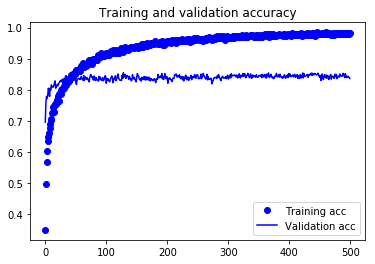

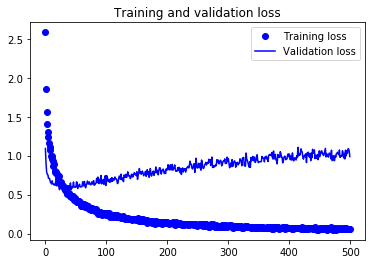

In [7]:
# 透過趨勢圖來觀察訓練與驗證的走向 (特別去觀察是否有"過擬合(overfitting)"的現象)
import matplotlib.pyplot as plt

# 把每個訓練循環(epochs)的相關重要的監控指標取出來
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# 取得整個訓練循環(epochs)的總次數
epochs = range(len(acc))

# 把"訓練準確率(Training acc)"與"驗證準確率(Validation acc)"的趨勢線形表現在圖表上
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# 把"訓練損失(Training loss)"與"驗證損失(Validation loss)"的趨勢線形表現在圖表上
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

從"Training與validation accuracy"的線型圖來看, 訓練到50~60循環(epochs)之後驗證的準確率就提不上去了, 但是訓練的準確率確可以一直提高。
雖然說83%的預測準確率在Kaggle的competition裡己經是前10名左右了, 但如果想要繼續提升效果的話可的的方向:
* 增加更多的字符圖像
* 字符圖像的增強的調教(可以增加如原文提及的影像頻導channel的flip,在這個文章為了簡化起見移除了這個部份的實作)

###  總結
在這篇文章中有一些個人學習到的一些有趣的重點:
* 如何使用Keras的ImageDataGenerator來增加模型訓練的圖像樣本
* 不同的網絡構建模型有不同的效果(VGG16, VGG19 等等),當不知道怎麼架構一個有效的網絡時可以先學習這些被驗證有效的結構
* 二階段的模型訓練想法及優化器(adadelta與adamax)的選用跟一般範例示範的有不一樣的想法
* 硬體(GPU)對於支持複雜的深度學習很重要，快速的回饋與結果才有機會和精神去嘗試其它的超參數與組合進而產生更好的模型

參考: 
* [Kaggle First Steps With Julia (Chars74k): First Place using Convolutional Neural Networks](http://ankivil.com/kaggle-first-steps-with-julia-chars74k-first-place-using-convolutional-neural-networks/)
* [Keras官網](http://keras.io/)